# Identify cross-page tables based on rules

This sample demonstrates how to use the output of Layout model and some business rules to identify cross-page tables. Once idenfied, it can be further processed to merge these tables and keep the semantics of a table.

Depending on your document format, there can be different rules applied to idenfity a cross-page table. This sample shows how to use the following rules to identify cross-page tables:

- If the 2 tables appear in consecutive pages
- And there's only page header, page footer or page number beteen them
- And the tables have the same number of columns

You can customize the rules based on your scenario.

## Prerequisites
- An Azure AI Document Intelligence resource - follow [this document](https://learn.microsoft.com/azure/ai-services/document-intelligence/create-document-intelligence-resource?view=doc-intel-4.0.0) to create one if you don't have.
- Get familiar with the output structure of Layout model - complete [this quickstart](https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/quickstarts/get-started-sdks-rest-api?view=doc-intel-4.0.0&pivots=programming-language-python#layout-model) to learn more.

## Setup

In [309]:
# ! pip install azure-ai-documentintelligence python-dotenv azure-identity

In [1]:
"""
This code loads environment variables using the `dotenv` library and sets the necessary environment variables for Azure services.
The environment variables are loaded from the `.env` file in the same directory as this notebook.
"""
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient

load_dotenv()

endpoint = "your-endpoint"
key = "your-documentint-key"
file_path = "your-filename.pdf"
custom_model_name = 'your-custom-model-name'

In [2]:
def get_table_page_numbers(table):
    """
    Returns a list of page numbers where the table appears.

    Args:
        table: The table object.

    Returns:
        A list of page numbers where the table appears.
    """
    return [region.page_number for region in table.bounding_regions]

In [3]:
def get_table_span_offsets(table):
    """
    Calculates the minimum and maximum offsets of a table's spans.

    Args:
        table (Table): The table object containing spans.

    Returns:
        tuple: A tuple containing the minimum and maximum offsets of the table's spans.
    """
    min_offset = table.spans[0].offset
    max_offset = table.spans[0].offset + table.spans[0].length

    for span in table.spans:
        if span.offset < min_offset:
            min_offset = span.offset
        if span.offset + span.length > max_offset:
            max_offset = span.offset + span.length

    return min_offset, max_offset

In [4]:
def find_merge_table_candidates(tables):
    """
    Finds the merge table candidates based on the given list of tables.

    Parameters:
    tables (list): A list of tables.

    Returns:
    list: A list of merge table candidates, where each candidate is a dictionary with keys:
          - pre_table_idx: The index of the first candidate table to be merged (the other table to be merged is the next one).
          - start: The start offset of the 2nd candidate table.
          - end: The end offset of the 1st candidate table.
    """
    merge_tables_candidates = []
    pre_table_idx = -1
    pre_table_page = -1
    pre_max_offset = 0

    for table_idx, table in enumerate(tables):
        min_offset, max_offset = get_table_span_offsets(table)
        table_page = min(get_table_page_numbers(table))
        
        # If there is a table on the next page, it is a candidate for merging with the previous table.
        if table_page == pre_table_page + 1:
            pre_table = {"pre_table_idx": pre_table_idx, "start": pre_max_offset, "end": min_offset}
            merge_tables_candidates.append(pre_table)
        
        print(f"Table {table_idx} has offset range: {min_offset} - {max_offset} on page {table_page}")

        pre_table_idx = table_idx
        pre_table_page = table_page
        pre_max_offset = max_offset

    return merge_tables_candidates

In [5]:
def check_paragraph_presence(paragraphs, start, end):
    """
    Checks if there is a paragraph within the specified range that is not a page header, page footer, or page number. If this were the case, the table would not be a merge table candidate.

    Args:
        paragraphs (list): List of paragraphs to check.
        start (int): Start offset of the range.
        end (int): End offset of the range.

    Returns:
        bool: True if a paragraph is found within the range that meets the conditions, False otherwise.
    """
    if not paragraphs is None:
        for paragraph in paragraphs:
            for span in paragraph.spans:
                if span.offset > start and span.offset < end:
                    # The logic role of a parapgaph is used to idenfiy if it's page header, page footer, page number, title, section heading, etc. Learn more: https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-layout?view=doc-intel-4.0.0#document-layout-analysis
                    if not hasattr(paragraph, 'role'):
                        return True
                    elif hasattr(paragraph, 'role') and paragraph.role not in ["pageHeader", "pageFooter", "pageNumber"]:
                        return True
    return False

In [6]:
def identify_cross_page_tables():
    """
    Identifies and merges tables that span across multiple pages in a document.
    
    Returns:
    None
    """
    document_intelligence_client = DocumentIntelligenceClient(
        endpoint=endpoint, credential=AzureKeyCredential(key)
    )

    

    # You can also use a URL instead of a local file with begin_analyze_document_from_url().
    with open(file_path, "rb") as f:
        poller = document_intelligence_client.begin_analyze_document(
            custom_model_name, analyze_request=f, content_type="application/octet-stream"  
        )

    result = poller.result()

    merge_tables_candidates = find_merge_table_candidates(result.tables)

    print("----------------------------------------")

    for i, candidate in enumerate(merge_tables_candidates):
        table_idx = candidate["pre_table_idx"]
        start = candidate["start"]
        end = candidate["end"]

       
        has_paragraph = check_paragraph_presence(result.paragraphs, start, end)
        # has_paragraph = False
        # If there is no paragraph within the range and the columns of the tables match, merge the tables.
        if not has_paragraph and result.tables[table_idx].column_count == result.tables[table_idx + 1].column_count:
            print(f"Merge table: {table_idx} and {table_idx + 1}")
            print("----------------------------------------")
    return result

The below output points if the two tables should be merged or not

In [7]:
result = identify_cross_page_tables()      

Table 0 has offset range: 52 - 1777 on page 1
Table 1 has offset range: 1830 - 4376 on page 2
----------------------------------------
Merge table: 0 and 1
----------------------------------------


If the two Tables, one in page 1 and page 2 can be merged, apply a logic as below

In [9]:
columns =['location','total','premium']
data = {'location':[],'total':[],'premium':[]}

for row in result['documents'][0]['fields']['tableLtI']['valueArray']:
    key_list = list(row['valueObject'].keys())
    for key in  key_list:
        if key in columns:
            data[key].append(row['valueObject'][key]['valueString'])

In [10]:
import pandas as pd
df = pd.DataFrame(data)
df

,location,total,premium
0,"1740 WEST BROADWAY Mesa, AZ 85201 County : 13",709.00,695.00 14.00 1.00
1,"11700 E. BERRY DRIVE DEWEY, AZ 86327 County 025",598.00,582.00 16.00 1.00
2,"4174 EAST HUNTINGTON #A FLAGSTAFF, AZ 86004 Co...","1,191.00",1179.00 12.00 1.00
3,"202 BUCKET OF BLOOD HOLBROOK, AZ 86025 County 017",631.00,619.00 12.00 1.00


## Without post processing

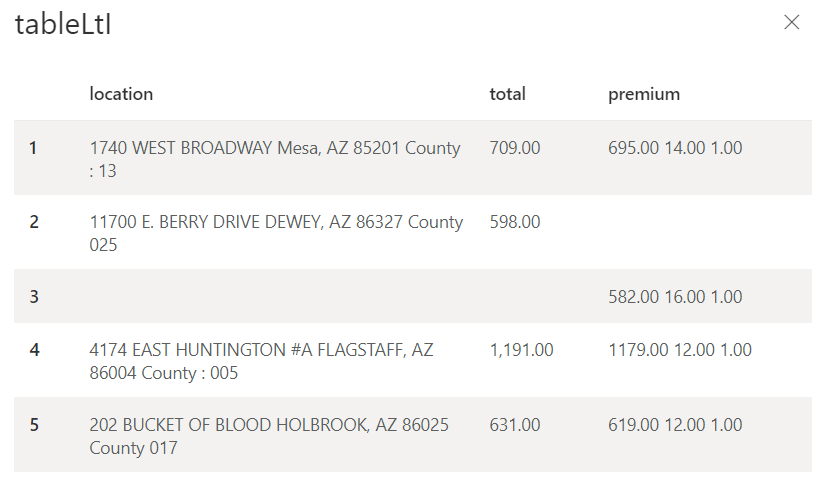

## With post processing

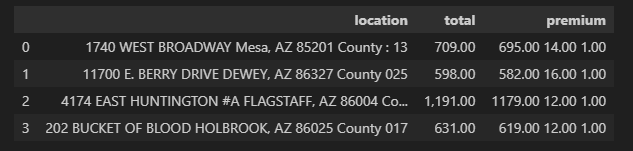